In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, box

from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx

def get_points(df, layers=5):
    ids = []
    if layers <= 0:
        return ids
    if df.shape[0] < 2:
        return ids
    df_sorted = df.sort_values("point_likelihood",ascending=False)
    top_point = df_sorted.centroid.iloc[1]
    ids.append(df_sorted.iloc[1].OBJECTID)
    df_bl = df.iloc[df.sindex.query(box(extremities[0], extremities[1], top_point.x, top_point.y))] # bottom left
    df_br = df.iloc[df.sindex.query(box(top_point.x, extremities[1], extremities[2], top_point.y))] # bottom right
    df_tl = df.iloc[df.sindex.query(box(extremities[0], top_point.y, top_point.x, extremities[3]))] # top left
    df_tr = df.iloc[df.sindex.query(box(top_point.x, top_point.y, extremities[2], extremities[3]))] # top right
    ids += get_points(df_bl, layers-1) + get_points(df_br, layers-1) + get_points(df_tl, layers-1) + get_points(df_tr, layers-1)
    return ids

In [254]:
df = gpd.read_file("Census_Blocks_in_2020.geojson")
df.to_crs("EPSG:4326",inplace=True)
df.index += 1
# add NEIGHBORS column
df["NEIGHBORS"] = None
extremities = np.array([df.centroid.x.min(), df.centroid.y.min(), df.centroid.x.max(), df.centroid.y.max()])  

for index, country in df.iterrows():   

    # get 'not disjoint' countries
    neighbors = df[~df.geometry.disjoint(country.geometry)].OBJECTID.tolist()

    # remove own name of the country from the list
    neighbors = [ name for name in neighbors if country.OBJECTID != name ]

    # add names of neighbors as NEIGHBORS value
    df.at[index, "NEIGHBORS"] = neighbors
    df["transit_potential"] = np.log(df['P0010001']/(df['ALAND'] + df['AWATER'])*1000 + 1)
df["point_likelihood"] = [df.loc[i]["transit_potential"] - (df.loc[df.NEIGHBORS.loc[i]]["transit_potential"].mean()) for i in range(1, df.shape[0] + 1)]

C:\Users\srjnk\AppData\Local\Temp\ipykernel_2848\2952183241.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  extremities = np.array([df.centroid.x.min(), df.centroid.y.min(), df.centroid.x.max(), df.centroid.y.max()])


In [255]:
points = df.loc[list(set(get_points(df)))]

C:\Users\srjnk\AppData\Local\Temp\ipykernel_2848\2205240150.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_point = df_sorted.centroid.iloc[1]


C:\Users\srjnk\AppData\Local\Temp\ipykernel_2848\4249817375.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.centroid.plot()


<Axes: >

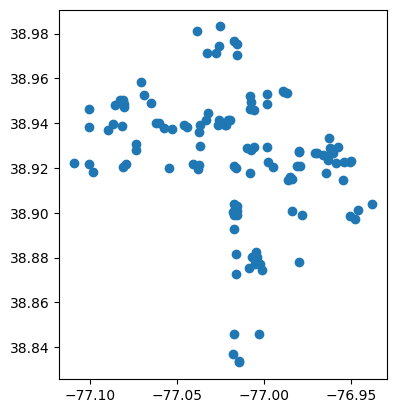

In [256]:
points.centroid.plot()

C:\Users\srjnk\AppData\Local\Temp\ipykernel_2848\3927224934.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_points = gpd.GeoDataFrame(geometry=points.centroid)
c:\Users\srjnk\Documents\metro_project\venv\Lib\site-packages\libpysal\weights\gabriel.py:145: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  return cls(point_array, ids=ids, **kwargs)
c:\Users\srjnk\Documents\metro_project\venv\Lib\site-packages\libpysal\weights\weights.py:1484: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid
c:\Users\srjnk\Documents\metro_project\venv\Lib\si

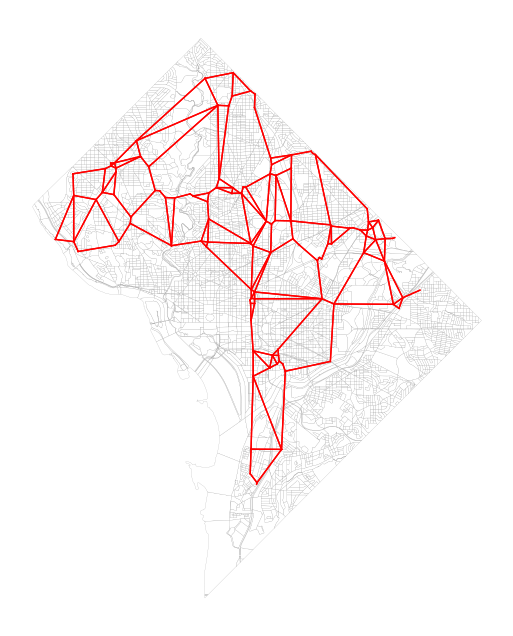

In [267]:
df_points = gpd.GeoDataFrame(geometry=points.centroid)
knn3 = weights.Gabriel.from_dataframe(df_points, use_index=True)
#knn_graph = knn3.to_networkx()
#coordinates = np.column_stack((df_points.geometry.x, df_points.geometry.y))
#positions = dict(zip(knn_graph.nodes, coordinates))

#nx.draw(knn_graph, positions, node_size=5, node_color="b")
ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
f,ax = knn3.plot(df, ax=ax,
        edge_kws=dict(color='r', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
plt.savefig("network_map")

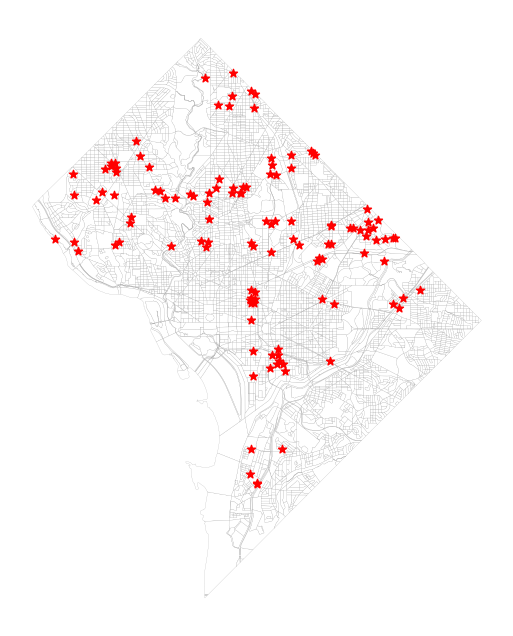

In [ ]:
'''ax = df.plot(edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("city_map")
plt.show()
ax = df.plot("transit_potential", edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("transit_potential")
plt.show()
ax = df.plot("point_likelihood", edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("point_likelihood")
plt.show()
ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
ax = df_points.plot(ax=ax, color='r', marker='*')
ax.set_axis_off()
plt.savefig("stations")'''
